# Lab7: Tumors in Rats

##### Keywords: rat tumors, MCMC, gibbs sampler, hierarchical, prior, noninformative prior, bayesian updating,  bayesian, posterior, posterior predictive, beta, binomial, beta-binomial

In [1]:
%matplotlib inline
import numpy as np
from scipy import stats
from scipy.stats import norm
from scipy.stats import beta
from scipy.stats import distributions
import matplotlib.pyplot as plt
import seaborn.apionly as sns
import time
sns.set_style('white')
sns.set_context('paper')

## Summary

A full bayesian treatment of the rat tumor hierarchical model, including a discussion on the choice of hyperprior, and posterior predictions.

---

This is an implementation of a [hierarchical]({{ links.hierarch }}) model from [Gelman](http://www.stat.columbia.edu/~gelman/book/), chapter 5. Gelman uses simulation there, but here we carry out full posteror simulations using MCMC.

The below data is from tumors in female rats of type "F344" that recieve a particular drug, in 70 different experiments. 

The first column is the number that get the tumor; the second is the total number or rats tested

## Data

In [2]:
tumordata="""0 20 
0 20 
0 20 
0 20 
0 20 
0 20 
0 20 
0 19 
0 19 
0 19 
0 19 
0 18 
0 18 
0 17 
1 20 
1 20 
1 20 
1 20 
1 19 
1 19 
1 18 
1 18 
3 27 
2 25 
2 24 
2 23 
2 20 
2 20 
2 20 
2 20 
2 20 
2 20 
1 10 
5 49 
2 19 
5 46 
2 17 
7 49 
7 47 
3 20 
3 20 
2 13 
9 48 
10 50 
4 20 
4 20 
4 20 
4 20 
4 20 
4 20 
4 20 
10 48 
4 19 
4 19 
4 19 
5 22 
11 46 
12 49 
5 20 
5 20 
6 23 
5 19 
6 22 
6 20 
6 20 
6 20 
16 52 
15 46 
15 47 
9 24 
"""

In [3]:
tumortuples=[e.strip().split() for e in tumordata.split("\n")]
tumory=np.array([np.int(e[0].strip()) for e in tumortuples if len(e) > 0])
tumorn=np.array([np.int(e[1].strip()) for e in tumortuples if len(e) > 0])
tumory, tumorn            

(array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  1,  1,
         1,  1,  1,  1,  1,  3,  2,  2,  2,  2,  2,  2,  2,  2,  2,  1,  5,
         2,  5,  2,  7,  7,  3,  3,  2,  9, 10,  4,  4,  4,  4,  4,  4,  4,
        10,  4,  4,  4,  5, 11, 12,  5,  5,  6,  5,  6,  6,  6,  6, 16, 15,
        15,  9]),
 array([20, 20, 20, 20, 20, 20, 20, 19, 19, 19, 19, 18, 18, 17, 20, 20, 20,
        20, 19, 19, 18, 18, 27, 25, 24, 23, 20, 20, 20, 20, 20, 20, 10, 49,
        19, 46, 17, 49, 47, 20, 20, 13, 48, 50, 20, 20, 20, 20, 20, 20, 20,
        48, 19, 19, 19, 22, 46, 49, 20, 20, 23, 19, 22, 20, 20, 20, 52, 46,
        47, 24]))

Now, a 71st experiment is done and we are told that 4 out of 14 rats develop tumors. Our problem is  to estimate the risk of tumor $\theta_{71}$ in these rats. 

## Model

Since we have historical data from 70 previous experiments to rely on, we can use that data to help us make this estimate, in a Bayesian manner, by calculating the posterior for $\theta_{71}$. 

In the $j$-th historical experiment, let the number of rats with tumors be $y_j$ and the total number of rats be $n_j$.
Since the rats either have or dont have the tumor, it makes sense to use a Binomial Model for **each** experiment, assumes a sample size $n_j$ and a probability $\theta_j$ that a rat has a tumor. For any one of the experiments

$$p(y_i \vert \theta_i; n_i) =  Binom(n_i, y_i, \theta_i) $$

and for all the data we have, using $Y=[y_1,\ldots, y_{70}]$ and $\Theta = [\theta_1, \ldots, \theta_{70}]$ and I use the notation
$\{n_i\} =[n_1, \ldots, n_{70}]$

$$ p(Y \vert \Theta; \{n_i\}) =  \prod_{i=1}^{70}Binom(n_i, y_i, \theta_i) $$


We now need to choose a prior $p(\Theta)$. Our first thought might be to use a Beta (conjugate prior to Binomial) for each $\theta_i$, i.e.

$$ \theta_i \sim Beta(\alpha_i, \beta_i).$$

$$p(\Theta \vert \{\alpha_i\}, \{\beta_i\}) = \prod_{i=1}^{70} Beta(\theta_i, \alpha_{i}, \beta_{i}),$$

where $\alpha_i$ and $\beta_i$ are what we called **hyperparameters**. Again I use the notation $\{\alpha_i\}=[\alpha_1, \ldots, \alpha_{70} ]$ and similarly for $\{beta\}$.

However, we would then come up with a very overfit model with 210 parameters and not much data. Besides, there are likely outliers in some experiments, small sample sizes, etc (this is called unpooled).

The other extreme is to assume that there is only one $\theta$ in the problem, and set an prior on it, making this a three parameter problem. This ignores any variation amongst the sampling units other than sampling variance, and such a model might thus be underfit, unable to capture the variations in the samples (complete pooling).

Let us compromise and assume that the $\theta_i$s are drawn from a "population distribution" given by a conjugate Beta prior $Beta(\alpha, \beta)$ with parameters $\alpha$ and $\beta$ to describe this data (partial pooling).

$$ \theta_i \sim Beta(\alpha, \beta).$$

$$p(\Theta \vert \alpha, \beta) = \prod_{i=1}^{70} Beta(\theta_i, \alpha, \beta).$$

This structure is shown in the diagram below.

![](images/hier.png)

Such a model is called a **hierarchical** model, with observable outcomes modeled conditionally on certain parameters($\theta$s) which themselves are given a probabilistic specification in terms of further parameters ($\alpha$ and $\beta$), known as **hyperparameters**.

Modeling in this way has two advantages: (a) as we shall see, it helps us develop a computational strategy to solve the problem, and (b) it allows estimates of the probabilities of any one of the units (here, one of the experiments) to borrow strength from all the data as a whole through the estimation of the hyperparameters. In other words, if some of the experiments had lower sample sizes or other outlier like behavior, the procedure helps "regularize" this.

## Empirical Bayes

The general idea behind empirical bayes is to use point estimates of $\alpha$ and $\beta$. One way to get such estimates is the method of moments, used on the prior distribution. Since the prior is the Beta distribution, we need to find the mean and variance of it:

$$\mu =  \frac{\alpha}{\alpha + \beta}$$

and

$$V  = \frac{\alpha\beta}{(\alpha + \beta)^2 (\alpha + \beta + 1)}$$

For the former, we'll take the average of the rates of the 70 experiments, and for the latter the variance of these rates.

In [24]:
tumor_rat = [e[0]/e[1] for e in zip(tumory, tumorn)]
tmean = np.mean(tumor_rat)
tvar = np.var(tumor_rat)
tmean, tvar

(0.13600653889043893, 0.010557640623609196)

In [25]:
aplusb = tmean*(1-tmean)/tvar - 1
a_est=aplusb*tmean
b_est=aplusb*(1.0 - tmean)
a_est, b_est

(1.3777748392916778, 8.7524354471531129)

Now we can use beta-binomial conjugacy to get the posterior rate estimates:

In [26]:
post_means = (a_est + tumory)/(a_est + b_est + tumorn)

And see how these compare to the observed ratios:

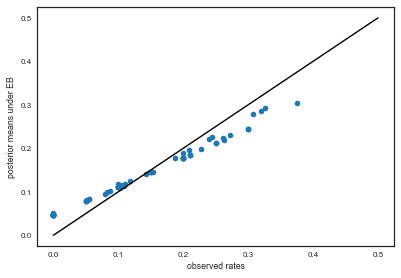

In [27]:
plt.plot(tumor_rat, post_means,'o')
plt.plot([0,0.5],[0,0.5],'k-')
plt.xlabel("observed rates")
plt.ylabel("posterior means under EB");

Exercise: how would you plot error bars on this graph?

As you can see, the posterior rates are shrunk towards flatness, which would correspond to complete pooling. The 45 degree line would be for completely unpooled estimate.

Now, for the 71st experiment, we have 4 out of 14 rats having tumors. The posterior estimate for this would be

$$\frac{\alpha + y_{71}}{\alpha + \beta + n_{71}}$$



In [28]:
4/14, (4+a_est)/(14+a_est+b_est)

(0.2857142857142857, 0.22286481449822493)

## Full Bayesian Treatment

To do that we need to specify a **hyper-priors** $p(\alpha, \beta)$ on these hyperparameters ($\alpha, \beta$). The idea of the hyper-prior is the same as that of a prior; except that the hyperpriors are priors on prior parameters.  We typically use uninformative hyperpriors: indeed this is one of the key strategies of hierarchical modelling: un-informative priors are pushed down the prior hierarchy.

We then write out a joint posterior distribution for the $\theta$s, $\alpha$ and $\beta$.

$$p( \theta_i, \alpha, \beta  \vert  y_i, n_i) \propto p(\alpha, \beta) \, p(\theta_i  \vert  \alpha, \beta) \, p(y_i  \vert  \theta_i, n_i,\alpha, \beta)$$

or for the whole dataset:

$$ p( \Theta, \alpha, \beta  \vert  Y, \{n_i\}) \propto p(\alpha, \beta) \prod_{i=1}^{70} Beta(\theta_i, \alpha, \beta) \prod_{i=1}^{70} Binom(n_i, y_i, \theta_i)$$

Note that this is a high dimensional problem: there are 72 parameters (70 $\theta$s and $\alpha , \beta$).

The **conditional** posterior distribution for each of the $\theta_i$, given everything else is a Beta distribution itself (remember Beta is conjugate prior to Bionomial).

$p(\theta_i  \vert  y_i, n_i, \alpha, \beta) = Beta(\theta_i, \alpha + y_i, \beta + n_i - y_i)$ 


For each of $\alpha$ and $\beta$, given everything else, the posterior distributions can be shown to be:

$$p(\alpha  \vert  Y, \Theta ,\beta ) \propto p(\alpha, \beta) \, \left(\frac{\Gamma(\alpha + \beta)}{\Gamma(\alpha)}\right)^N \prod_{i=1}^{N} \theta_i^{\alpha}$$

$$P(\beta  \vert  Y, \Theta ,\alpha ) \propto p(\alpha, \beta) \, \left(\frac{\Gamma(\alpha + \beta)}{\Gamma(\beta)}\right)^N \prod_{i=1}^{N} (1 - \theta_i)^{\beta}$$

Note: The conditional posteriors do depend on $Y$ and $\{n\}$ via the $\theta$'s. 

### Choosing a hyperprior

The hyperparameters $\alpha$ and $\beta$ are hard to interpret for the putpose of setting up a hyper-prior distribution.

So let us consider instead, 
the 'prior' mean $\mu$ of the beta population distribution for $\{\theta_i\}$ is given by $\frac{\alpha}{\alpha + \beta}$, and the variance is given by $\frac{\mu (1-\mu)}{\alpha +\beta +1}$. 

We'll use non-informative priors here, although you could use a weakly informative prior such as $Cauchy(0,1)$ on the standrd deviation.

But notice the following approximation:

$$\sigma \approx \sqrt{\frac{\mu(1-\mu)}{\alpha+\beta}} $$

(looks like the sampling error on a binomial wth prior numbers put in! Not surprising as this is a Beta.)

Now, $p(\mu, \sigma) = p(\sigma \vert \mu)p(\mu)$, and notice that for constant $\mu$ the $\sigma$ dependence is on $1/\sqrt{\alpha + \beta}$. Thus we transform to variables $\mu$ and $s =  1/\sqrt{\alpha + \beta}$.

Now $dP(\alpha, \beta) = dP(\mu, s)$, and so:

$$\pi(\alpha, \beta) d\alpha d\beta =  p(s(\alpha, \beta) \vert \mu(\alpha, \beta)) p(\mu(\alpha, \beta))\mid\frac{\partial(\mu(\alpha, \beta), s(\alpha, \beta))}{\partial(\alpha, \beta)}\mid d\alpha d\beta$$

We thus choose to set up a uniform prior on 

$$\left(\frac{\alpha}{\alpha + \beta}, (\alpha + \beta)^{-1/2}\right),$$

where we have used

$$ d\mu ds = J d\alpha d\beta$$

and written the jacobian in this strange partial derivative notation.

Now, non-informative priors means that  $p(\sigma \vert \mu)$ and $p(\mu)$ are both $\propto 1$, and the Jacobian is proportional to  $(\alpha + \beta)^{-5/2}$

Thus we are yielded a hyperprior $p(\alpha, \beta) \sim (\alpha + \beta)^{-5/2}$.  

This is not the only scheme via which an uninformative (or for that matter, weakly informative) hyperprior distribution which will be dominated by the likelihood can be set, and it is worth exploring other options, such as other powers of $(\alpha + \beta)$.



## Sampling 

We construct a combined Gibbs sampler and MH sampler using the above conditionals: the draws for the $\theta_i$ is simple because of conjugacy. But for $\alpha$ and $\beta$, we implement a Metropolis-Hastings sampler, use a normal proposal with mean the current values of $\alpha$ and $\beta$  and standard deviations 0.25 and 3 respectively, remembering to reject negative values from the proposal. Each step of the 70 gibbs samplers are alternated with each step of the MH sampler for $\alpha$ and $\beta$. 



In [4]:
# number of thetas
numthetas=tumorn.shape[0]
numthetas

70

### Using logs

So far we have used distributions directly for our sampling.  This is a bad idea for large numbers of parameters (here we have 72). Small numbers multiply smaller and we can get underflow fast. Its better to subtract -72 from -56 than to do $\frac{10^{-56}}{10^{-72}}$. Thus for our posterior computations in the acceptance ratio, we must take logs

We set up python functions for each draw

In [5]:
from scipy.special import gammaln

# prior for the hyperparameters
def log_prior(a, b):
    if a <= 0 or b <=0:
        return -np.inf
    return -2.5*np.log(a + b)

# sampling from conditional posterior for the theta
draw_thetas = lambda a,b: beta.rvs(a+tumory,b+tumorn-tumory, size=numthetas)

# conditional posterior (pdf) for alpha
def log_cond_alpha(a,b, thetas):
    if a <= 0 or b <=0:
        return -np.inf
    return numthetas*(gammaln(a+b) - gammaln(a)) + a*np.sum(np.log(thetas)) + log_prior(a,b)
   
# conditional posterior (pdf) for beta
def log_cond_beta(a,b, thetas):
    if a <= 0 or b <=0:
        return -np.inf
    return numthetas*(gammaln(a+b) - gammaln(b)) + b*np.sum(np.log(1.0 - thetas)) + log_prior(a,b)
  
# using the above pdfs we draw for alpha and beta in MH fashion
def draw_alpha(a,b,thetas,proposal_sd, accepts):
    astar = norm.rvs(a,proposal_sd)  # proposed a new alpha
    num = log_cond_alpha(astar,b, thetas) 
    den = log_cond_alpha(a,b, thetas)
    R=np.random.rand()
    if (np.log(R) <= num - den): 
        accepted=1
    else:
        accepted=0
    accepts['alpha'] = accepts['alpha'] + accepted
    if accepted:
        return astar
    else:
        return a

def draw_beta(a,b,thetas,proposal_sd, accepts):
    bstar = norm.rvs(b,proposal_sd)
    num = log_cond_beta(a,bstar, thetas)
    den = log_cond_beta(a,b, thetas)
    R=np.random.rand()
    if (np.log(R) <= num - den):
        accepted=1
    else:
        accepted=0
    accepts['beta'] = accepts['beta'] + accepted
    if accepted:
        return bstar
    else:
        return b

We initialize variables for our sampler.

In [6]:
burnin=20000
numtraces=200000
totaltraces=burnin+numtraces

alphas=np.empty(totaltraces)
betas=np.empty(totaltraces)
thetas=np.empty((totaltraces, numthetas))

# these are the step sizes for the proposal distribution
# for our M-H sampling for alpha and beta to be used in Gibbs sampling later
alpha_prop_sd=0.6
beta_prop_sd=3.2

#start positions
alphas[0]=1.
betas[0]=1.
thetas[0,:] = (tumory+0.5)/(tumorn+0.5)

#draw_thetas(alphas[0], betas[0])
accepteds={'alpha':0, 'beta':0}

This is the main loop of our sampler. Notice the structure: for alpha we take from the previous step, for beta we take the changed alpha from the current step, and for the thetas we take both alpha and beta from the current step.

In [7]:
start = time.clock()

for m in np.arange(1,totaltraces):
    alphas[m] = draw_alpha(alphas[m-1],betas[m-1],thetas[m-1,:], alpha_prop_sd, accepteds)
    betas[m] = draw_beta(alphas[m],betas[m-1],thetas[m-1,:], beta_prop_sd, accepteds)
    thetas[m,:] = draw_thetas(alphas[m],betas[m])

print("sampling took: ", time.clock()-start, " seconds.")

sampling took:  75.007415  seconds.


Check our acceptance ratio, and then remove burnin samples and thin

In [8]:
accepteds['alpha']/numtraces, accepteds['beta']/numtraces

(0.357195, 0.430315)

In [9]:
#remove burnin samples and thin
thin=40
alphatrace=alphas[burnin+1:totaltraces:thin]
betatrace=betas[burnin+1:totaltraces:thin]
thetastrace=thetas[burnin+1:totaltraces:thin,:]
print(thetastrace.shape, alphatrace.shape)

(5000, 70) (5000,)


#### Traces and autocorrelation
We check our traces.

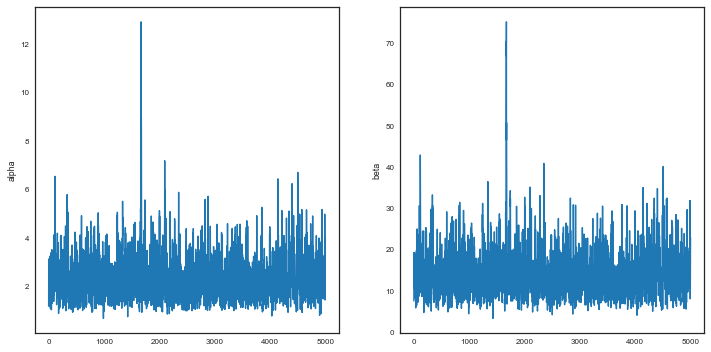

In [10]:
plt.figure(figsize=[12,6])
plt.subplot(1,2,1)
plt.plot(alphatrace)
plt.ylabel('alpha')
plt.subplot(1,2,2)
plt.plot(betatrace)
plt.ylabel('beta')

In [11]:
def corrplot(trace, maxlags=50):
    plt.acorr(trace-np.mean(trace),  normed=True, maxlags=maxlags);
    plt.xlim([0, maxlags])

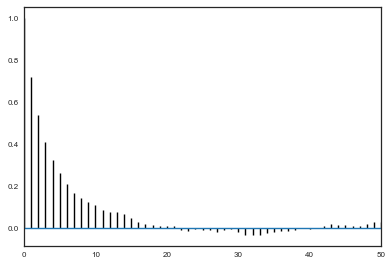

In [12]:
corrplot(alphatrace)

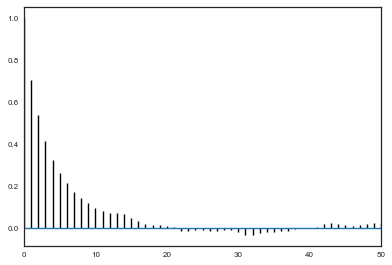

In [13]:
corrplot(betatrace)

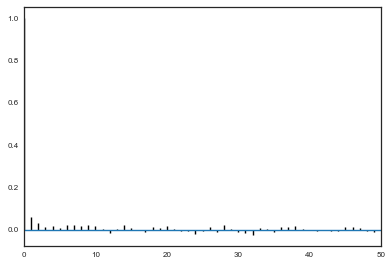

In [14]:
corrplot(thetastrace[:,7])

## The posterior 

We plot the $\alpha$ and $\beta$ marginals and create a 2D histogram or KDE plot (`sns.kdeplot` in seaborn) of the marginal posterior density in the space $x = \alpha/\beta$, $y = log(\alpha + \beta)$. We also look at the marginal of $\theta_1$.

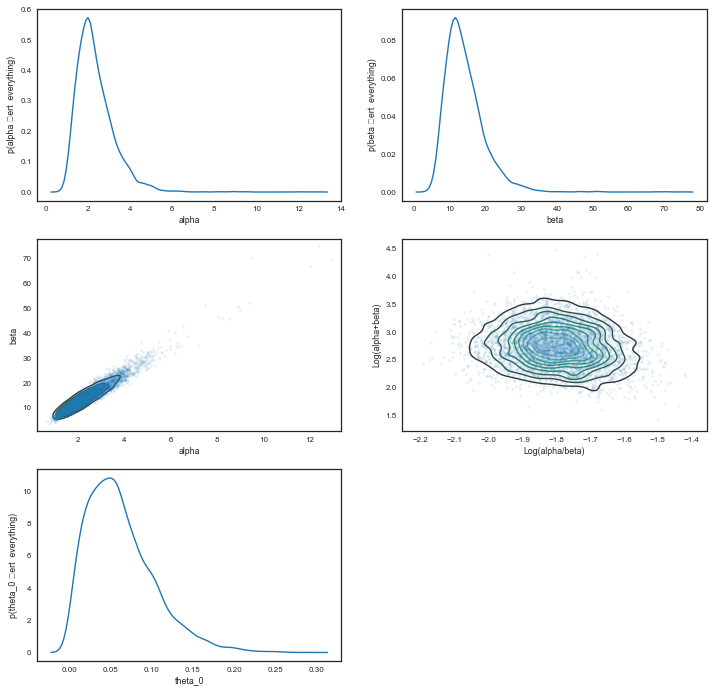

In [15]:
plt.figure(figsize=[12,12])
plt.subplot(3,2,1)
sns.kdeplot(alphatrace)
plt.xlabel('alpha')
plt.ylabel('p(alpha \vert  everything)')
plt.subplot(3,2,2)
sns.kdeplot(betatrace)
plt.xlabel('beta')
plt.ylabel('p(beta \vert  everything)')
plt.subplot(3,2,3)
plt.plot(alphatrace, betatrace,'.', alpha=0.1)
sns.kdeplot(alphatrace, betatrace)
plt.xlabel('alpha')
plt.ylabel('beta')

plt.subplot(3,2,4)
plt.plot(np.log(alphatrace/betatrace), np.log(alphatrace+betatrace),'.', alpha=0.1)
sns.kdeplot(np.log(alphatrace/betatrace), np.log(alphatrace+betatrace))
plt.xlabel('Log(alpha/beta)')
plt.ylabel('Log(alpha+beta)')

plt.subplot(3,2,5)
sns.kdeplot(thetastrace[:,0])
plt.xlabel('theta_0')
plt.ylabel('p(theta_0 \vert  everything)')

### Understanding the posterior

We plot the observed tumor rates on the x-axis against posterior medians for each of the 70 $\theta$'s on the y axis, along with error bars obtained from finding the 2.5 and 97.5 percentiles. 



In [16]:
percentiles=np.percentile(thetastrace, [2.5,50.0, 97.5], axis=0)
lowerthetas, medianthetas, upperthetas=percentiles

elowertheta = medianthetas - lowerthetas
euppertheta = upperthetas - medianthetas

If we would not be so clever Bayesian this would have been our tumor rates:

In [17]:
empirical_ratios=tumory/tumorn

Here we compare the two

(-0.1, 0.5)

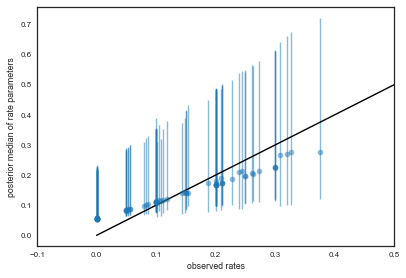

In [18]:
plt.errorbar(empirical_ratios, 
             medianthetas, yerr=[lowerthetas,upperthetas], fmt='o', alpha=0.5)
plt.plot([0,0.5],[0,0.5],'k-')
plt.xlabel("observed rates")
plt.ylabel("posterior median of rate parameters")

plt.xlim(-0.1,0.5)

## The predictives

In a hierarchical model, there are two kinds of posterior predictions that are useful. (1) The distribution of future observations $\tilde{y}$ given a $\theta_i$, and (2) The distribution of observations $\tilde{y}$ drawn from a future $\theta_j$ drawn from the super-population (i.e. using the Beta on the estimated hyper parameters).

The first kind of posterior predictive is easy to get, since we have traces of all the $\theta$s:

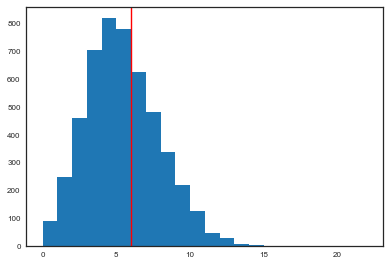

In [19]:
from scipy.stats import binom
pred60 = binom.rvs(tumorn[60],thetastrace[:,60])
plt.hist(pred60, bins=np.arange(tumorn[60]));
plt.axvline(tumory[60],0,1,color='r');

### The 71st experiment


We wish to understand what happens for the 'future' $\theta_{71}$.
and then, finally, compute the posterior prediction for the 71st experiment.

To do this remember the conditional structure of our problem. $\theta_{71}$'s parents in the graph are $\alpha$ and $\beta$ so it suffices to sample from them (marginalize over them) to get the $\theta_{71}$ posterior.

$$p(\theta_{71}, \theta_{1..70}, \alpha, \beta \vert  D)  \propto p(y_{71} \vert n_{71}, \theta_{71} ) p(\theta_{71} \vert \alpha, \beta) p(\theta_{1..70}, \alpha, \beta \vert  D)$$

In other words the full posterior so far (for the 70 experiments) becomes the new prior for experiment 71. We need to mix in a prior for $\theta_{71}$ as well, and then the likelihoof for $y_{71}$. Then we simply marginalize over everything to get the $\theta_{71}$ posterior.

$$p(\theta_{71} \vert \theta_{1..70}, \alpha, \beta, D) = \int d\alpha \,d\beta \,d\theta_{1..70} \,p(\theta_{71}, \theta_{1..70}, \alpha, \beta \vert  D)$$

$$ =  \int d\alpha \,d\beta  Beta(\alpha+y_{71}, \beta + n_{71} - y_{71})  \int_{\theta_{1..70}} \,d\theta_{1..70} \,p(\theta_{1..70}, \alpha, \beta \vert  D)$$

In [20]:
post71 = beta.rvs(alphatrace+4, betatrace+10)

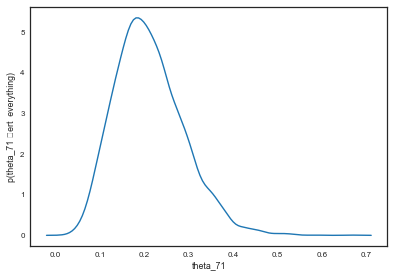

In [21]:
sns.kdeplot(post71)
plt.xlabel('theta_71')
plt.ylabel('p(theta_71 \vert  everything)');

In [22]:
# numpy function falttens by default
percentiles =np.percentile(post71, [2.5,50.0, 97.5])

print("Percentiles: ", percentiles)
print("Naive rate: ", 4.0/14)

Percentiles:  [ 0.08584507  0.20284944  0.38120849]
Naive rate:  0.2857142857142857


And the predictive can be trivially calculated looking at the posterior samples.

### The structure of Bayesian updating

Notice something about the posterior of $\theta_71$. Its exact after the 71st experiment, because to obtain it we had to marginalize over everything else. But the formulas for the posteriors for all the other parameters have changed, because we ought to be marginalizing over $\theta_{71}$ for them as well.  Thus the samples for these parameters will no-longer be representative of the true posteriors...they are not borrowing any "statistical juice" fromn the $\theta_{71}$ samples.

What you would have to do is to take the previous steps posterior,  make a kernel density estimate of it, and use that as a prior on  $\alpha, \beta, \theta_{1..70}$. Multiply in the prior of $\theta_{71}$ and you have the full prior, now write the full likelihood and  thus obtain the full posterior. We do, however, lose our conjugacy and sampling is less fun (and all MH).